<a href="https://colab.research.google.com/github/oliverzannino/oliverza/blob/main/2025AssignmentPart3_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2025</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 3</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />

In all the tasks below, suppose that current default–free interest rates are 3.5% continuously compounded, for all maturities. Suppose further that a corporate entity has issued &euro;120 million of corporate debt (only), paying no coupons and maturing in 10 years. This entity has a market capitalisation of &euro;28 million and the volatility of its share price is approximately 45%.

<H2>Task 1:</H2>
Using the Black-Scholes/Merton model of credit risk as explained in Lecture 7, determine the value of the debt. What is the credit spread (in terms of continuously compounded yields) for this entity? <I>(5 marks)</I>

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

# Parameters
F = 120000000
E = 28000000
r = 0.035
T = 10
sigma_E = 0.45

# Precompute e^{-rT}
exp_minus_rT = np.exp(-r * T)
F_disc = F * exp_minus_rT

# Initial guesses
V_guess = E + F_disc
sigma_guess = sigma_E * (E / V_guess)

# System of equations
def equations(x):
    V, sigma_V = x
    d1 = (np.log(V / F) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d2 = d1 - sigma_V * np.sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    eq1 = V * N_d1 - F * exp_minus_rT * N_d2 - E
    eq2 = (V / E) * N_d1 * sigma_V - sigma_E
    return [eq1, eq2]

# Solve the system
initial_guess = [V_guess, sigma_guess]
solution = fsolve(equations, initial_guess)
V, sigma_V = solution

# Compute debt value, yield, and spread
debt_value = V - E
y = - (1 / T) * np.log(debt_value / F)
spread = y - r

# Results (rounded for readability)
print(f"Asset value V: €{V:.4f}")
print(f"Asset volatility σ_V: {sigma_V:.4f}")
print(f"Value of the debt: €{debt_value:.4f}")
print(f"Credit spread s: {spread:.10f} (or {spread * 10000:.2f} bps)")

print(f"Check: V0 ≈ E + D → {V:.4f} ≈ {E:.4f} + {debt_value:.4f} = {E+debt_value:.4f}")

Asset value V: €97892009.7318
Asset volatility σ_V: 0.1823
Value of the debt: €69892009.7318
Credit spread s: 0.0190540410 (or 190.54 bps)
Check: V0 ≈ E + D → 97892009.7318 ≈ 28000000.0000 + 69892009.7318 = 97892009.7318


<H2>Task 2:</H2>
Assume now that the default-free bond price dynamics and firm's value process are given by
\begin{eqnarray*}
\frac{dB(t,T)}{B(t,T)}&=&rdt+\sigma_r\cdot(T-t)dW_1(t)\\
\frac{dV(t)}{V(t)}&=&rdt+\sigma_V\left(\rho
dW_1(t)+\sqrt{1-\rho^2}dW_2(t)\right)
\end{eqnarray*}
with $W_1$ and $W_2$ independent Brownian motions under the spot risk-neutral measure. Assume further that the firm defaults at time $\tau$ if
$$
V(\tau)<B(\tau,T)K
$$
where $T$ is the maturity of the debt and $K$ is the face value of the debt. In the event of default at time $\tau$, the debt holders receive a total of $KcB(\tau,T)$ at time $\tau$.

In addition to the information given above, assume $\rho=-0.4$ and $\sigma_r=0.018$. Determine the value of the debt as a function of $c$. Plot the credit spread (in terms of continuously compounded yields) for this entity as a function of $c$ for $0<c<1$. <I>(7 marks)</I>

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

def barrier_default_bond_price(V0, K, B0_T, r, T, sigma_V, sigma_r, rho, c):
    k  = np.log(V0 / (B0_T * K))
    Q  = (sigma_V**2)*T - rho*sigma_V*sigma_r*(T**2) + (sigma_r**2)*(T**3)/3
    sQ = np.sqrt(Q)
    P  = norm.cdf((k + 0.5*Q)/sQ) - np.exp(-k)*norm.cdf((-k + 0.5*Q)/sQ)
    B_frac = B0_T * (1 - (1 - c)*(1 - P))  # price as fraction of face
    return B_frac, P, k, Q

def credit_spread_cc(B_defaultable, B_riskfree, T):
    return (-np.log(B_defaultable)/T) - (-np.log(B_riskfree)/T)

# Inputs (millions)
r       = 0.035
T       = 10
K       = 120          # €mm
rho     = -0.4
sigma_r = 0.018
E_mkt   = 28           # €mm
sigma_E = 0.45

# Calibrate V0 and sigma_V from Merton
def _calib(params):
    V, sigma_V = params
    d1 = (np.log(V/K) + (r + 0.5*sigma_V**2)*T) / (sigma_V*np.sqrt(T))
    d2 = d1 - sigma_V*np.sqrt(T)
    E_val = V*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    dE_dV = norm.cdf(d1)
    sigma_E_val = (dE_dV*V/E_val)*sigma_V if E_val > 0 else 0.0
    return [E_val - E_mkt, sigma_E_val - sigma_E]

V0, sigma_V = fsolve(_calib, [E_mkt + K*np.exp(-r*T), 0.30])
B0_T = np.exp(-r*T)

# Header
print("Given Parameters:")
print(f"Risk-free Rate (r): {r:,.2%}")
print(f"Time to Maturity (T): {T} years")
print(f"Face Value of Debt (K): €{K:.0f} million")
print(f"Correlation (ρ): {rho}")
print(f"Interest Rate Volatility (σ_r): {sigma_r:.6%}")
print(f"Market Capitalization (E): €{E_mkt:.0f} million")
print(f"Equity Volatility (σ_E): {sigma_E:.0%}\n")

print("Calibrated Parameters (from Merton Model):")
print(f"Firm Value (V0): €{V0:.4f} million")
print(f"Firm Volatility (σ_V): {sigma_V*100:.4f}%\n")

print(f"Risk-free Bond Price B(0,T): {B0_T:.6f}")
print(f"Risk-free Bond Value: €{(B0_T*K):.4f} million\n")

# Results table
c_values = np.round(np.linspace(0.0, 1.0, 11), 1)
print("RESULTS TABLE\n")
print(f"{'Index':<6} {'c (recovery)':<14} {'Debt Value (EUR mm)':<22} {'Spread (bps)':<12}")

rows = []
for i, c in enumerate(c_values):
    B_frac, P_surv, k, Q = barrier_default_bond_price(V0, K, B0_T, r, T, sigma_V, sigma_r, rho, c)
    debt_value_mm = B_frac * K
    spread_bps = credit_spread_cc(B_frac, B0_T, T) * 1e4
    rows.append((i, c, debt_value_mm, spread_bps, P_surv))
    print(f"{i:<6d} {c:<14.1f} {debt_value_mm:<22.2f} {spread_bps:<12.1f}")

# Midpoint line
c_mid = 0.5
B_mid, P_mid, k_mid, Q_mid = barrier_default_bond_price(V0, K, B0_T, r, T, sigma_V, sigma_r, rho, c_mid)
spread_mid = credit_spread_cc(B_mid, B0_T, T)
print("\nMidpoint (c = 0.5):")
print(f"Debt Value: €{(B_mid*K):.2f} million")
print(f"Spread: {spread_mid*100:.4f}% ({spread_mid*1e4:.1f} bps)")
print(f"P_survival: {P_mid*100:.4f}%")

Given Parameters:
Risk-free Rate (r): 3.50%
Time to Maturity (T): 10 years
Face Value of Debt (K): €120 million
Correlation (ρ): -0.4
Interest Rate Volatility (σ_r): 1.800000%
Market Capitalization (E): €28 million
Equity Volatility (σ_E): 45%

Calibrated Parameters (from Merton Model):
Firm Value (V0): €97.8920 million
Firm Volatility (σ_V): 18.2277%

Risk-free Bond Price B(0,T): 0.704688
Risk-free Bond Value: €84.5626 million

RESULTS TABLE

Index  c (recovery)   Debt Value (EUR mm)    Spread (bps)
0      0.0            18.70                  1509.1      
1      0.1            25.28                  1207.3      
2      0.2            31.87                  975.8       
3      0.3            38.46                  787.9       
4      0.4            45.04                  629.9       
5      0.5            51.63                  493.4       
6      0.6            58.22                  373.3       
7      0.7            64.80                  266.1       
8      0.8            71.39   

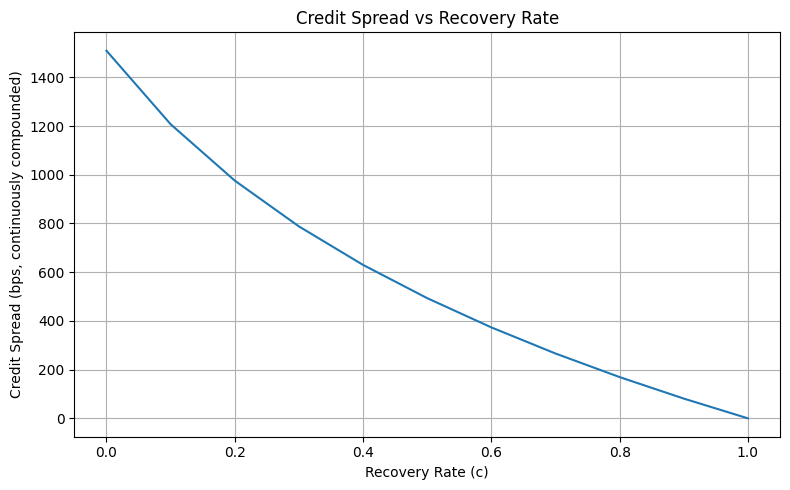

In [ ]:
import matplotlib.pyplot as plt

c_vals = [row[1] for row in rows]
spreads_bps = [row[3] for row in rows]

plt.figure(figsize=(8,5))
plt.plot(c_vals, spreads_bps)
plt.xlabel('Recovery Rate (c)')
plt.ylabel('Credit Spread (bps, continuously compounded)')
plt.title('Credit Spread vs Recovery Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

<H2>Task 3:</H2>
Returning to a model where interest rates are deterministic and default only occurs at maturity when $V(T)<K$, i.e. when the firm's value at maturity is less than the face value of the outstanding debt, consider a Poisson process $N$ with intensity $\lambda$ under the risk-neutral measure. Let $(U_i)_{i\geq1}$ be a sequence of i.i.d. random variables with expectation $\nu$. Assume that the $\sigma$-fields generated by $W$, $N$ and $(U_i)_{i\geq1}$ are mutually independent under the risk-neutral measure.
Define
$$
\pi(t)=\sum_{i=1}^{N(t)}U_i
$$
and write the dynamics of $V$ as
$$
dV(t)=V(t-)((r-\lambda\nu)dt+\sigma_VdW_{\beta}(t)+\Delta\pi(t))
$$
Assume further that the $U_i+1$ are lognormally distributed, i.e.
$$
\ln(U_i+1)\sim\mathcal{N}(\mu,\sigma)
$$
Write a Python function which calculates the credit spread (in terms of continuously compounded yields) for this entity, taking as inputs (in this order) $V(0)$, $K$, $T$, $r$, $\sigma_V$, $\lambda$, $\mu$ and $\sigma$.  <I>(8 marks)</I>

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

#1, Standard normal cdf
def Phi(x: float) -> float:
    return 0.5*(1.0 + math.erf(x / math.sqrt(2.0)))

#2, E[min(K,X)] for X~LogNormal(m_ln, s2_ln)
def expected_min_under_lognormal(m_ln, s2_ln, K_f):
    lnK = math.log(K_f)
    s   = math.sqrt(max(s2_ln, 1e-16))
    ins_1   = (lnK - m_ln) / s
    ins_2   = (lnK - m_ln - s2_ln) / s
    P     = 1 - Phi(ins_1)
    E2  = math.exp(m_ln + 0.5*s2_ln) * Phi(ins_2)
    #E[min(K, X)]= K*P(X>=K) + E[X 1_{X<K}]
    return K_f*P + E2

#3, Debt price under jump-diffusion
def debt_price_jump_merton(V0, K, T, r, sigma_V, lam, mu, sig,
                           tol=1e-12, nmin=50):
    #Jump mean       nu = E[J-1]= exp(μ+1/2*σ^2)-1   with J = e^{Normal(mu, sig^2)}
    nu = math.exp(mu + 0.5*sig**2) - 1.0
    #Poisson mean (m = λT)
    m = lam * T
    #Truncation
    nmax = max(nmin, int(math.ceil(m + 10.0*math.sqrt(m + 1e-12))))
    #Accumulate
    p_n = math.exp(-m)  #p_0
    E_min = 0.0
    for n in range(0, nmax + 1):
        #Conditional lognormal parameters for ln V_T|N(T)=n
        m_n  = math.log(V0) + (r - lam*nu - 0.5*sigma_V**2)*T + n*mu
        s2_n = sigma_V**2 * T + n*(sig**2)
        E_min += p_n * expected_min_under_lognormal(m_n, s2_n, K)
        #Poisson recursion p_{n+1} = p_n * m/(n+1)
        p_n *= m / (n + 1.0)
        if p_n < tol and n > m + 5.0*math.sqrt(m + 1e-12):
            break
    #Discount back
    return math.exp(-r*T) * E_min

#4) Credit spread under jump-diffusion
def credit_spread_jump(V0, K, T, r, sigma_V, lam, mu, sig):
    D0 = debt_price_jump_merton(V0, K, T, r, sigma_V, lam, mu, sig)
    #Continously compounded yield of defautable ZCB, (1/T)ln(K/D0)
    y_debt = (1.0/T) * math.log(K / D0)               #get zcb from price D0
    #Credit spread
    spread = y_debt - r
    return spread, D0


In [ ]:
#parameters pre-defined

V0 = 97.892
K = 120
T = 10
r = 0.035
sigma_V = 0.182

#new ones
lam = 0.1
mu = -0.1
sig = 0.2

print("Input Parameters (rounded):")
print(f"V(0): {V0}")
print(f"K: {K:.0f}")
print(f"T: {T:g}")
print(f"r: {r:.3f}")
print(f"sigma_V: {sigma_V}")
print(f"lambda: {lam:.2f}")
print(f"mu (jump): {mu:.2f}")
print(f"sigma (jump): {sig:.2f}\n")

#Print result
spread_cc, D0 = credit_spread_jump(V0, K, T, r, sigma_V, lam, mu, sig)

print(f"\nDebt value D0 (EUR): {D0:.8f}")
print(f"Credit spread : {spread_cc:.8f} (or {spread_cc * 10000:.2f} bps)")


Input Parameters (rounded):
V(0): 97.892
K: 120
T: 10
r: 0.035
sigma_V: 0.182
lambda: 0.10
mu (jump): -0.10
sigma (jump): 0.20


Debt value D0 (EUR): 68.66029236
Credit spread : 0.02083207 (or 208.32 bps)
